In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import random
import math
from scipy.spatial.distance import euclidean, pdist, squareform
import timeit
import time
%matplotlib notebook
import scipy.stats as sts
import multiprocessing as mp

In [82]:
ATOMIC_WEIGHTS = {'H':1.008, 'HE':4.002602, 'LI':6.94, 'BE':9.012182,
       'B':10.81, 'C':12.011, 'N':14.007, 'O':15.999, 'F':18.9984032,
       'NE':20.1797, 'NA':22.98976928, 'MG':24.305, 'AL':26.9815386,
       'SI':28.085, 'P':30.973762, 'S':32.06, 'CL':35.45, 'AR':39.948,
       'K':39.0983, 'CA':40.078, 'SC':44.955912, 'TI':47.867, 'V':50.9415,
       'CR':51.9961, 'MN':54.938045, 'FE':55.845, 'CO':58.933195,
       'NI':58.6934, 'CU':63.546, 'ZN':65.38, 'GA':69.723, 'GE':72.630,
       'AS':74.92160, 'SE':78.96, 'BR':79.904, 'RB':85.4678, 'SR':87.62,
       'Y':88.90585, 'ZR':91.224, 'NB':92.90638, 'MO':95.96, 'TC':98,
       'RU':101.07, 'RH':102.90550, 'PD':106.42, 'AG':107.8682, 'CD':112.411,
       'IN':114.818, 'SN':118.710, 'SB':121.760, 'TE':127.60, 'I':126.90447,
       'XE':131.293, 'CS':132.9054519, 'BA':137.327, 'LA':138.90547,
       'CE':140.116, 'PR':140.90765, 'ND':144.242, 'PM':145, 'SM':150.36,
       'EU':151.964, 'GD':157.25, 'TB':158.92535, 'DY':162.500, 'HO':164.93032,
       'ER':167.259, 'TM':168.93421, 'YB':173.054, 'LU':174.9668, 'HF':178.49,
       'TA':180.94788, 'W':183.84, 'RE':186.207, 'OS':190.23, 'IR':192.217,
       'PT':195.084, 'AU':196.966569, 'HG':200.592, 'TL':204.38, 'PB':207.2,
       'BI':208.98040, 'PO':209, 'AT':210, 'RN':222, 'FR':223, 'RA':226,
       'AC':227, 'TH':232.03806, 'PA':231.03588, 'U':238.02891, 'NP':237,
       'PU':244, 'AM':243, 'CM':247, 'BK':247, 'CF':251, 'ES':252, 'FM':257,
       'MD':258, 'NO':259, 'LR':262, 'RF':267, 'DB':268, 'SG':269, 'BH':270,
       'HS':269, 'MT':278, 'DS':281, 'RG':281, 'CN':285, 'UUT':286, 'FL':289,
       'UUP':288, 'LV':293, 'UUS':294}


class Solvate:
    def __init__(self,pdb_file, water_box="water.pdb", neighbours=4, iterations=20, ncpus = os.cpu_count()):
        self.pdb_file = self.read_pdb(pdb_file)
        self.water_box = self.read_pdb(water_box)
        self.neighbours = neighbours
        self.iterations = iterations
        self.ncpus = ncpus
        
    def read_pdb(self, pdb, include='ATOM,HETATM'):
        """
        Reads in pdb file
        Returns
            coordinates (dictionary): dictionary containing coordinates for atoms in pdb
            Center of Mass (tuple): tuple containing coordinates of the center of mass
        """
        com = self.center_of_mass(pdb)
        include = tuple(include.split(','))
        coordinates = {}
        with open(pdb) as f:
            g = f.read().splitlines()
            for line in [i for i in g if i.startswith(include)]:
                resnum = int(line[22:27].strip())
                chain = line[21]
                atom_name = line[13:17].strip()
                if "%s:%s" % (chain,resnum) not in coordinates.keys():
                    coordinates["%s:%s" % (chain,resnum)] = {}
                
                coordinates["%s:%s" % (chain,resnum)][atom_name] = [float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                       ]
            f.close()
        print(resnum)
        return coordinates, com
            
    def center_of_mass(self, pdb, include='ATOM,HETATM'):
        """
        Calculates center of mass of a protein and/or ligand structure.
        Returns:
            center (list): List of float coordinates [x,y,z] that represent the
            center of mass (precision 3).
        """

        center = [None, None, None]
        include = tuple(include.split(','))

        with open(pdb, 'r') as pdb:

            # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
            coordinates = []
            masses = []    
            for line in pdb:
                if line.startswith(include):
                    coordinates.append([float(line[30:38]),    # x_coord
                                        float(line[38:46]),    # y_coord
                                        float(line[46:54])     # z_coord
                                       ])
                    element_name = line[76:].strip()
                    if element_name not in ATOMIC_WEIGHTS:
                        element_name = line.split()[2].strip()[0]
                    masses.append(ATOMIC_WEIGHTS[element_name])

            assert len(coordinates) == len(masses)

            # calculate relative weight of every atomic mass
            total_mass = sum(masses)
            weights = [float(atom_mass/total_mass) for atom_mass in masses]

            # calculate center of mass
            center = [sum([coordinates[i][j] * weights[i]
                  for i in range(len(weights))]) for j in range(3)]
            center_rounded = [round(center[i], 3) for i in range(3)]
            return center_rounded
        
    def translate_coords(self,coords, com, new_center=(0,0,0)):
        """
        Translates coordinates to a new center of mass (default: 0,0,0)
        Returns:
            coords (dictionary): dictionary containing translated coordinates
        """
        
        new_coords = {}
        shift = np.array(new_center) - np.array(com)
        print(shift)
        
        for k,v in coords.items():
            new_coords[k] = {}
            for k1,v1 in v.items():
                new_coords[k][k1] = [round(i,3) for i in list(np.array(v1) + shift)]
        
        return new_coords
    
    def random_rotation(self):
        """
        Applies a random rotation to the protein coordinates to self.pdb_file
        Returns:
            rotated (dictionary): dictionary containing rotated coordinates
        """
        angle = math.radians(random.uniform(0,360))
        
        choices = ['x','y','z']
        choice = random.choice(choices)
        
        rotated = {}
        
        ox,oy,oz = self.pdb_file[1]
        
        for k,v in self.pdb_file[0].items():
            rotated[k] = {}
            for k1,v1 in v.items():
                px, py, pz = v1
                
                if choice == 'x':
                    p_rot_x = px-ox
                    p_rot_y = (py-oy)*math.cos(angle) - (pz-oz)*math.sin(angle)
                    p_rot_z = (pz-oz)*math.cos(angle) + (py-oy)*math.sin(angle)
                elif choice == 'y':
                    p_rot_y = py-oy
                    p_rot_x = (px-ox)*math.cos(angle) - (pz-oz)*math.sin(angle)
                    p_rot_z = (pz-oz)*math.cos(angle) + (px-ox)*math.sin(angle)
                else:
                    p_rot_z = pz-oz
                    p_rot_y = (py-oy)*math.cos(angle) - (px-ox)*math.sin(angle)
                    p_rot_x = (px-ox)*math.cos(angle) + (py-oy)*math.sin(angle)
                
                rotated[k][k1] = [p_rot_x,p_rot_y,p_rot_z]
        
#         rotated_centered = self.translate_coords()
                
        return rotated
    
    def remove_clash_waters_process(self,w,atoms):
        for a in atoms:
            w = np.array(w)
            a = np.array(a)
            dist = np.linalg.norm(w - a)
            x = False
            if dist < 2.6:
                x = True
                break
            if not x:
                self.water_no_clash.append(w.tolist())
                
        
    def remove_clash_waters(self, coords):
        """
        Returns new water dictionary removing clashes with protein
        """
        water_clash = self.trim_box().tolist()
        self.water_no_clash = []
        atoms = []
#         print(type(water_no_clash))
        for kp,vp in coords.items():
#             print(kp)
            for vp1 in vp.values():
                atoms.append(vp1)
            
        processes = [mp.Process(target=self.remove_clash_waters_process,args=(w,atoms)) for w in water_clash]
        
        process_run = []

        pi = 0
        for p in processes:
                pi+=1
                if pi <= self.ncpus:
                        process_run.append(p)
                else:
                        pi = 0
                        for pp in process_run:
                                pp.start()
                        for pp in process_run:
                                pp.join()
                        process_run = []
        for pp in process_run:
            pp.start()
        for pp in process_run:
            pp.join()
            
#             break
                            
        return self.water_no_clash
    
    def water_box_to_array(self):
        """
        Transfers self.water_box to numpy array containing only oxygen coordinates
        """
        arr = []
        for v in self.water_box[0].values():
            arr.append(v['OW'])
        return np.array(arr)
    
    def furthest_point(self):
        """
        Calculates largest distance from protein center in a PDB structure.
        Returns:
            Largest distance (Float)
        """
        coords = self.pdb_file[0]
        com  = self.pdb_file[1]
        
        max_dist = 0
        
        for v in coords.values():
            for v1 in v.values():
                dist = euclidean(com,v1)
                if dist > max_dist:
                    max_dist = dist
                    
        return max_dist
    
    def trim_box(self, pad=2):
        """
        Returns reduced numpy array water box with a radius of max distance + pad
        """
        wat = self.water_box_to_array()
        wat_trim = []
        
        com = np.array([0,0,0])
        
        max_dist = self.furthest_point() + pad
        for w in [i for i in wat if np.linalg.norm(com-np.array(i)) < max_dist]:
            wat_trim.append(w)
        
        return np.array(wat_trim)
    
    def remove_bulk_water(self,water,neighbours=4):
        """
        Returns list with non-bulk water removed
        """
        dists = [1 if len([j for j in i if j < 4.2]) > neighbours else 0 for i in squareform(pdist(wat))]
        
        return [i for i,j in zip(water,dists) if j]
    
    def get_distances(self, coords, water):
        """
        Returns a dictionary with atomic distances to nearest bulk water
        """
        d_dists = {}
        for k,v in coords.items():
            d_dists[k] = {}
            for k1,v1 in v.items():
                x = 0
                for w in water:
                    x+=1
                    w = np.array(w)
                    v1 = np.array(v1)
                    dist = np.linalg.norm(w - v1)
                    if x==1:
                        min_dist = dist
                    else:
                        if dist < min_dist:
                            min_dist = dist
                
                d_dists[k][k1] = min_dist
                
        return d_dists
    
    def get_res_distances(self, dists):
        """
        Returns a dictionary with average depth for residues (averaged over atoms for each residue)
        """
        return {k:np.mean(list(v.values())) for k,v in dists.items()}
    
    def run(self):
        """
        Run residue depth
        """
        if self.ncpus == 1:
            for i in range(self.iterations):
                d_rot = self.random_rotation()
                wat = self.remove_clash_waters(d_rot)
                bulk_wat = self.remove_bulk_water(wat)
                dists = solv.get_distances(d_rot,bulk_wat)
                res_depths = solv.get_res_distances(dists)

In [28]:
new_lines = []
with open("water.pdb") as f:
    g = f.read().splitlines()
    for line in g:
        if line.startswith('ATOM'):
            if int(line[6:12]) > 29997 and int(line[6:12]) < 59997:
                chain = 'B'
            elif int(line[6:12]) > 59997 and int(line[6:12]) < 89997:
                chain = 'C'
            elif int(line[6:12]) > 89997:
                chain = 'D'
            else:
                chain='A'
            splt = list(line)
            splt[21] = chain
            line = "".join(splt)
            new_lines.append(line)
        else:
            new_lines.append(line)
    f.close()
    
with open("water.pdb","w+") as f:
    for line in new_lines:
        f.write("%s\n" % line)
    f.close()

In [50]:
solv = Solvate("native.pdb")
pdb = solv.pdb_file
water = solv.water_box

trans_pdb = solv.translate_coords(pdb[0],pdb[1])
# trans_water = solv.translate_coords(water[0],water[1])

328
2773
[-40.85  -35.951 -16.902]


<IPython.core.display.Javascript object>


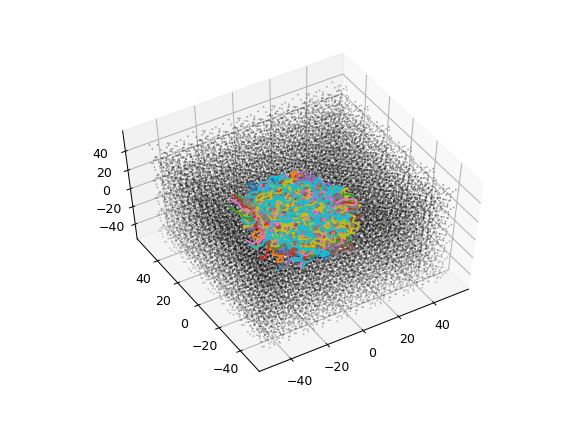

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,20):
    x = []
    y = []
    z = []
    
    d_rot = solv.random_rotation()
    
    for k,v in d_rot.items():
        coord = v['CA']
        x.append(coord[0])
        y.append(coord[1])
        z.append(coord[2])
    
    ax.plot(x,y,z)
    
ax.scatter(wat_x, wat_y, wat_z, marker='.', s=0.2, color='k')
    
plt.show()

In [35]:
for i in range(0,20):
    print(i)
    d_rot = solv.random_rotation()
    wat = solv.remove_clash_waters(d_rot)
    print(len(wat))
    

0
7516
1
7514
2
7515
3
7515
4
7513
5
7515
6
7515
7
7514
8
7516
9
7514
10
7513
11
7515
12
7515
13
7515
14
7514
15
7515
16
7515
17


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


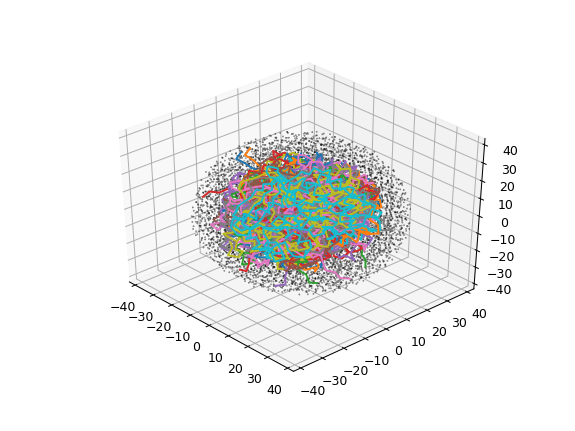

In [266]:
wat = solv.trim_box()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,20):
    x = []
    y = []
    z = []
    
    d_rot = solv.random_rotation()
    
    for k,v in d_rot.items():
        coord = v['CA']
        x.append(coord[0])
        y.append(coord[1])
        z.append(coord[2])
    
    ax.plot(x,y,z)

ax.scatter(wat[:,0],wat[:,1],wat[:,2],marker='.',s=0.5, color='k')
plt.show()

In [267]:
a = np.array([[1,2,3],[4,5,6]])
b = [7,8,9]
np.linalg.norm(a-b,axis=-1)

array([10.39230485,  5.19615242])

In [252]:
d_rot

{'A:36': {'N': [-23.492, 26.205032959042548, 7.466523998186421],
  'CA': [-23.104000000000003, 25.255268673179835, 6.438790666383035],
  'C': [-22.553, 25.889839798293792, 5.171686689918751],
  'O': [-22.55, 27.11745709264052, 5.054431504017097]},
 'A:37': {'N': [-22.084000000000003, 25.03829910366512, 4.2445969178948575],
  'CA': [-21.606, 25.39821225084321, 2.9041240436865197],
  'CB': [-20.662000000000003, 26.618645226160815, 2.952459876744493],
  'CG': [-20.05, 27.341621103388714, 1.7333725620100005],
  'CD1': [-18.907, 26.585152866887675, 1.0547203630413282],
  'CD2': [-21.146, 27.68884796467633, 0.7226087385574846],
  'C': [-20.886000000000003, 24.201660769968385, 2.2713819527708967],
  'O': [-20.006, 24.387976963723194, 1.421713619864037]},
 'A:38': {'N': [-21.257, 22.97164580347572, 2.6588134721443817],
  'CA': [-20.424000000000003, 21.787173544602364, 2.445845239866763],
  'CB': [-20.079, 21.10824060024691, 3.784482628060008],
  'CG': [-18.972, 21.8237521084162, 4.526337251067

In [271]:
print(squareform(pdist(wat)))

[[ 0.          2.8071872  13.46984339 ... 69.3711198  72.4591521
  71.72046209]
 [ 2.8071872   0.         11.3186095  ... 71.15444274 73.71807325
  72.9047439 ]
 [13.46984339 11.3186095   0.         ... 74.41358077 74.4544074
  73.56026102]
 ...
 [69.3711198  71.15444274 74.41358077 ...  0.         17.34748976
  18.621     ]
 [72.4591521  73.71807325 74.4544074  ... 17.34748976  0.
   2.98989966]
 [71.72046209 72.9047439  73.56026102 ... 18.621       2.98989966
   0.        ]]


In [19]:
d_rot = solv.random_rotation()
start = time.time()
wat = solv.remove_clash_waters2(d_rot)
end = time.time()
print(end - start)

0.8120419979095459


In [329]:
len(wat)

15533626

<IPython.core.display.Javascript object>


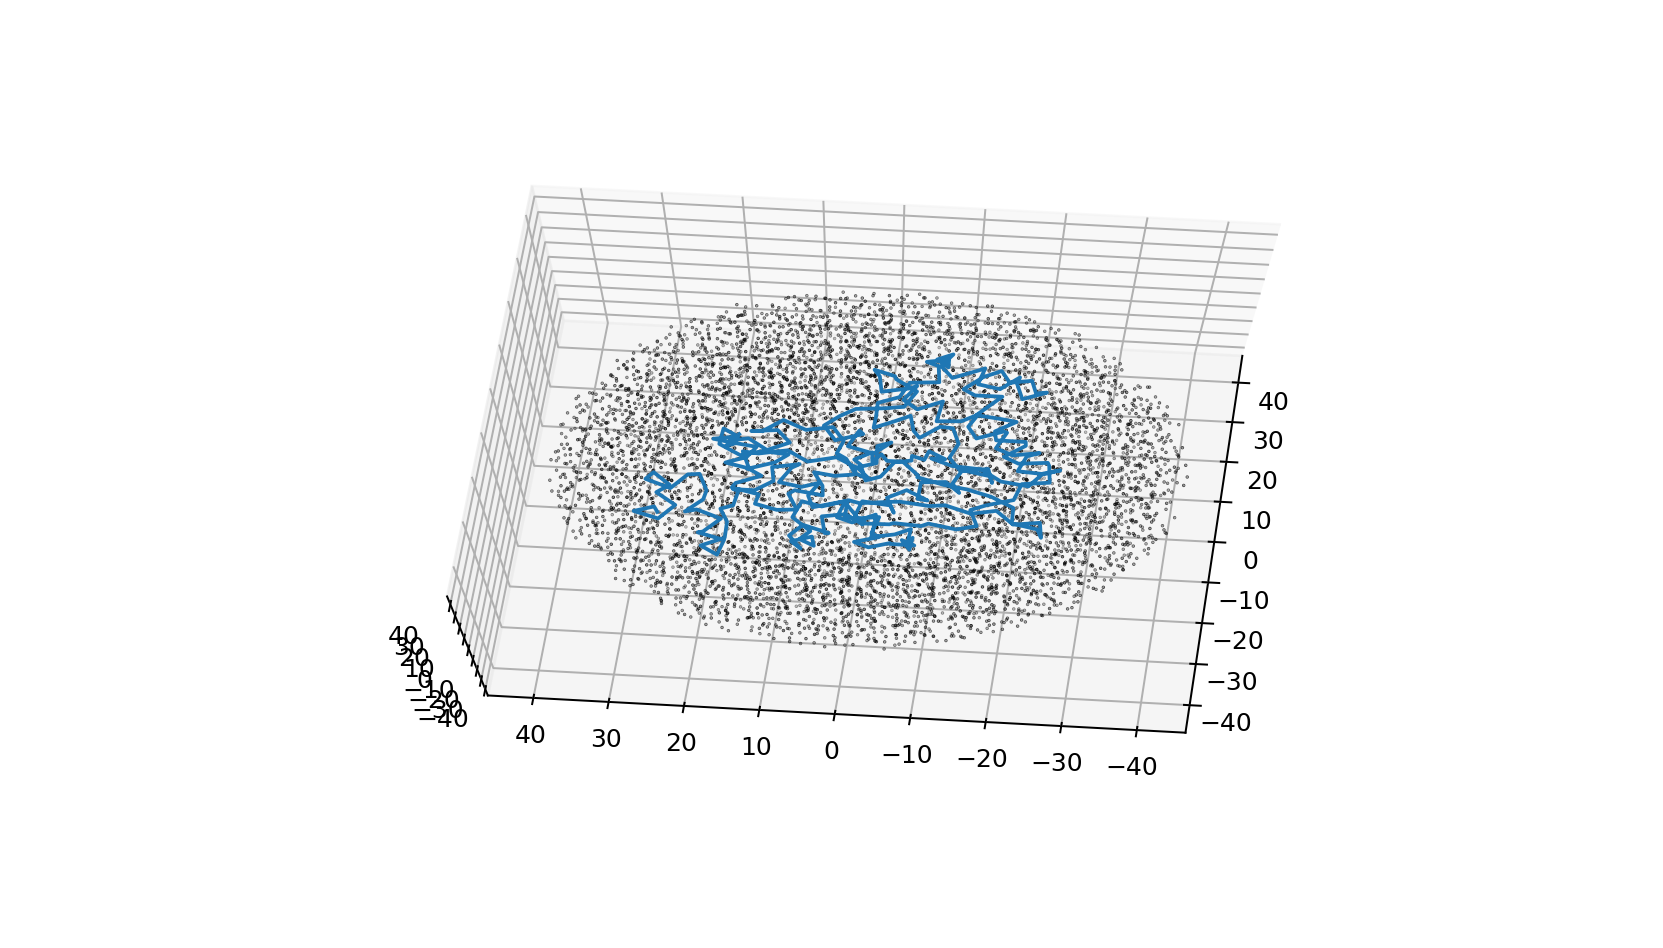

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []

# d_rot = solv.random_rotation()

for k,v in d_rot.items():
    coord = v['CA']
    x.append(coord[0])
    y.append(coord[1])
    z.append(coord[2])

ax.plot(x,y,z)

watx = []
waty = []
watz = []

for w in bulk_wat:
    watx.append(w[0])
    waty.append(w[1])
    watz.append(w[2])

ax.scatter(watx,waty,watz,marker='.',s=0.5, color='k')
plt.show()

In [83]:
start_tot = time.time()
solv = Solvate("native.pdb",neighbours=2)
pdb = solv.pdb_file
water = solv.water_box

trans_pdb = solv.translate_coords(pdb[0],pdb[1])
d_rot = solv.random_rotation()
start = time.time()
wat = solv.remove_clash_waters(d_rot)
bulk_wat = solv.remove_bulk_water(wat)
end = time.time()
print("Water removed in: %s" % str(end-start))
start = time.time()
dists = solv.get_distances(d_rot,bulk_wat)
res_depths = solv.get_res_distances(dists)
end = time.time()
print("Distances calculated in: %s" % str(end - start))
end_tot = time.time()

print("Total time: %s" % str(end_tot-start_tot))

328
2773
[-40.85  -35.951 -16.902]


OSError: [Errno 24] Too many open files

In [72]:
print(len(wat), len(bulk_wat))


5866 5678


In [73]:
dists

{'A:36': {'N': 3.860676213118067,
  'CA': 3.9879586069682995,
  'C': 3.7984630603245835,
  'O': 2.946307211328603},
 'A:37': {'N': 3.7501800856024095,
  'CA': 4.10027841755923,
  'CB': 3.2196238983118706,
  'CG': 3.2343342112752747,
  'CD1': 2.868064599838227,
  'CD2': 3.7841913667152043,
  'C': 3.5295977007572783,
  'O': 2.845390244290404},
 'A:38': {'N': 4.1889192894576155,
  'CA': 4.573285001469681,
  'CB': 3.4234245015232334,
  'CG': 3.745569490137189,
  'OD1': 3.177909963495494,
  'OD2': 3.3211146550503803,
  'C': 3.587738551472058,
  'O': 2.748376656833359},
 'A:39': {'N': 4.093225765980042,
  'CA': 4.131861376270726,
  'CB': 3.2500699066667718,
  'CG1': 2.714287815032277,
  'CG2': 3.047793296394983,
  'CD1': 3.4065166352232357,
  'C': 4.34002454539866,
  'O': 3.7408436304156623},
 'A:40': {'N': 4.658762012138566,
  'CA': 4.657969925907504,
  'CB': 5.079849238871639,
  'CG': 3.989915602403551,
  'CD1': 3.3388873107003327,
  'CD2': 3.387430453120925,
  'C': 3.8255234419762765,
  '

In [36]:
gt = {}

with open('native-atom.depth') as f:
    g = f.read().splitlines()
    for line in g[1:]:
        if line.split()[1] not in gt.keys():
            gt[line.split()[1]] = {line.split()[2]:float(line.split()[3])}
        else:
            gt[line.split()[1]][line.split()[2]] = float(line.split()[3])
    f.close()

<IPython.core.display.Javascript object>


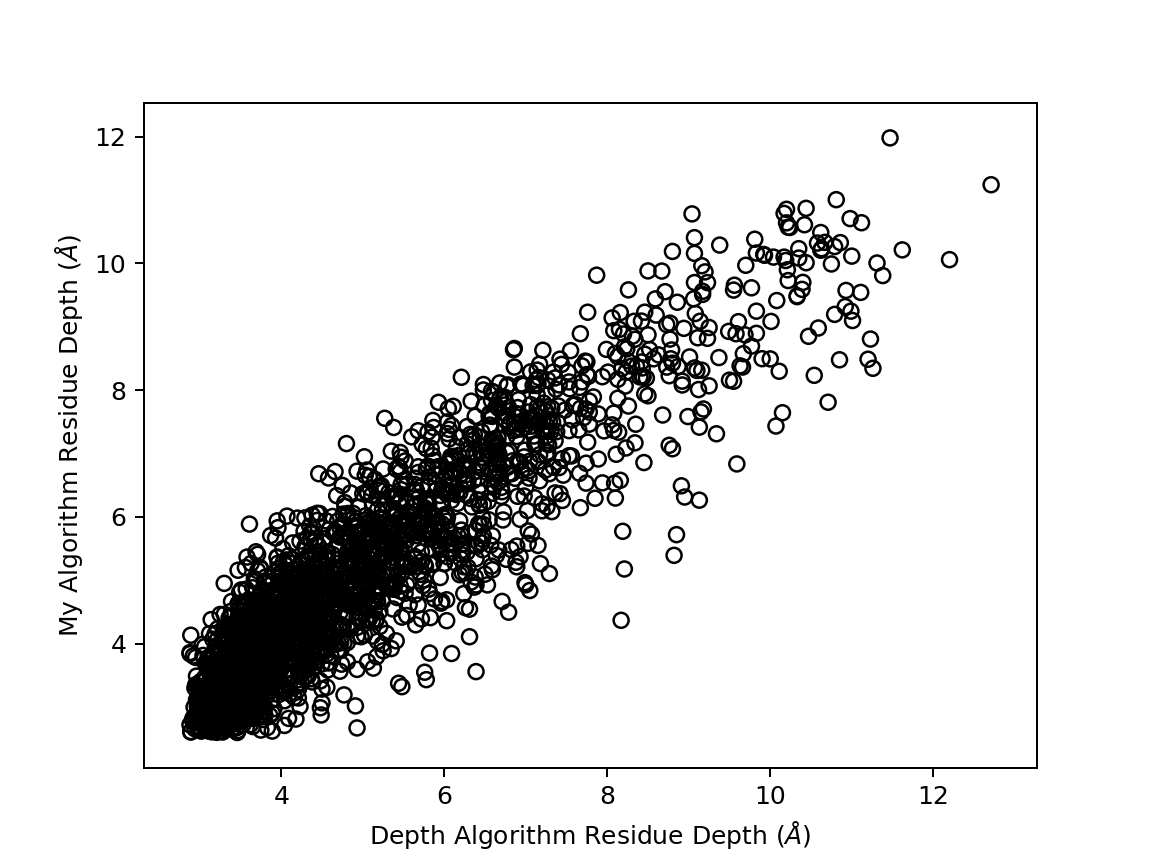

In [76]:
gt_list = []
my_list = []

for k in gt:
    for k2 in gt[k]:
        plt.scatter(gt[k][k2],dists[k][k2],facecolor='none',edgecolor='k')
        gt_list.append(gt[k][k2])
        my_list.append(dists[k][k2])

plt.xlabel(r"Depth Algorithm Residue Depth ($\AA$)")
plt.ylabel(r"My Algorithm Residue Depth ($\AA$)")
plt.show()

In [54]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

@my_decorator
def say_whee():
    print("Whee!")

In [56]:
say_whee()

Something is happening before the function is called.
Whee!
Something is happening after the function is called.


In [75]:
sts.spearmanr(gt_list,my_list)

SpearmanrResult(correlation=0.8890856208364625, pvalue=0.0)